<a href="https://colab.research.google.com/github/kavyajeetbora/monitoring_water_surface_area/blob/master/notebooks/monitoring_inland_water_area_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Monitoring Inland Surface Water Area

In [ ]:
import geemap
import ee
import shapely
from datetime import datetime
import matplotlib.pyplot as plt

ee.Authenticate()
ee.Initialize(project='kavyajeetbora-ee')

## Area of Interest

Used this tool to create a geojson file of the area of interest:

[keene Polyline Tool](https://www.keene.edu/campus/maps/tool/?coordinates=77.1200409%2C%2011.5324541%0A76.9923248%2C%2011.5062217%0A76.9916382%2C%2011.3467571%0A77.1529998%2C%2011.4261642%0A77.1200409%2C%2011.5324541)

In [ ]:
geojson  = {
  "coordinates": [
    [
      [
        77.1200409,
        11.5324541
      ],
      [
        76.9941101,
        11.5006165
      ],
      [
        76.9701462,
        11.4243672
      ],
      [
        77.0055084,
        11.3198347
      ],
      [
        77.1529998,
        11.4261642
      ],
      [
        77.1200409,
        11.5324541
      ]
    ]
  ],
  "type": "Polygon"
}

geometry = ee.Geometry(geojson)

## Downloading the Global Surface Water data

[JRC Global Surface Water Data](https://developers.google.com/earth-engine/datasets/catalog/JRC_GSW1_4_YearlyHistory): This dataset contains maps of the location and temporal distribution of surface water from 1984 to 2021 and provides statistics on the extent and change of those water surfaces

Visualize the masked surface water data on map for a particular year:

In [ ]:
image_collection = ee.ImageCollection("JRC/GSW1_4/YearlyHistory")\
.filter(ee.Filter.bounds(geometry))\
.filter(ee.Filter.eq('year', 1999))

image = image_collection.first()
isWaterImage = image.eq(2).Or(image.eq(3))

isWaterImage = isWaterImage.selfMask()

Map = geemap.Map()
visParams = {'palette': ['blue']}
Map.addLayer(isWaterImage.clip(geometry), visParams)
Map.centerObject(geometry, zoom=9)
Map

Map(center=[11.437008883357802, 77.05579366889911], controls=(WidgetControl(options=['position', 'transparent_…

## Calculate the total area

Calculate the total surface water area based on whether or not the pixel is classified as water

In [ ]:
def getWaterSurfaceArea(image):

    areaImage = image.multiply(ee.Image.pixelArea())
    totalArea = areaImage.reduceRegion(
        reducer = ee.Reducer.sum(),
        geometry = geometry,
        scale=30,
        maxPixels = 1e10
    )

    totalArea = ee.Number(totalArea.get('waterClass')).divide(1e6).round()

    return image.set('area_km2', totalArea)

## Calculate the total area for all images:

There might be few images with 0 total area, maybe because there wasn't enough data for that area in that particular year

In [ ]:
image_collection = ee.ImageCollection("JRC/GSW1_4/YearlyHistory")\
.filter(ee.Filter.bounds(geometry))

areaImages = image_collection.map(getWaterSurfaceArea)

## Extract the year and area values

After calculating the total area for all the image in the collection, extract the year and the total area property from each image for plotting:

In [ ]:
def extract_time_series(image_collection, stat='area_km2'):
    '''
    Extract timeseries values, the area values and corresponding the year
    '''

    image_list = image_collection.getInfo()['features']
    properties = [img['properties'] for img in image_list]

    xs, ys = [], []
    for prop in properties:
        x,y = prop['year'], prop[stat]
        xs.append(x), ys.append(y)

    return xs, ys

def plot_time_series(x,y):
    '''
    Plot the time series given the x - year, y - area for example
    and return a matplotlib figure
    '''

    fig,ax = plt.subplots(figsize=(15,3))
    ax.plot(x,y)
    ax.set_xlabel("Year")
    ax.set_ylabel('Surface Water Area (km2)')
    ax.set_title("Total Surface Water Area")
    return fig

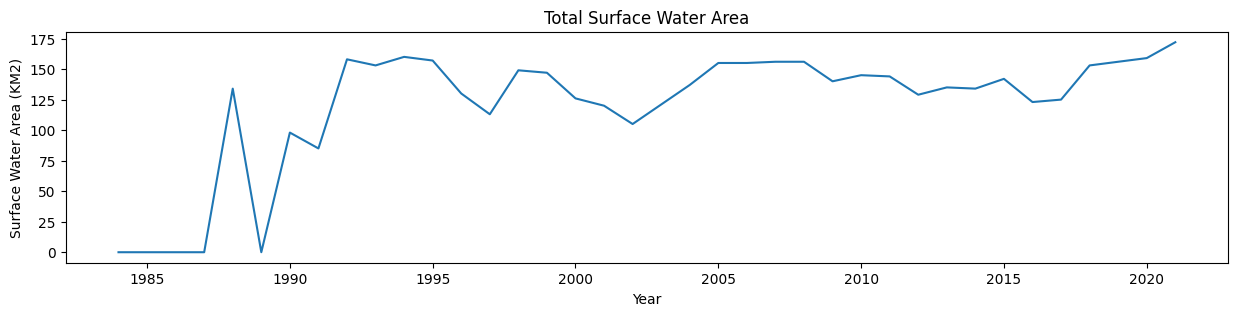

In [ ]:
xs,ys = extract_time_series(areaImages)
fig = plot_time_series(xs,ys)

There was no data found in the initial years due to lack of image data present for this location. Maybe because of lower temporal resolution in those years.

### Visualize the time series on map (optional)

Note: This might lag in the notebook

In [ ]:
Map = geemap.Map()

vis_params = {'min': 0, 'max': 1, 'palette': ['#ece7f2','#a6bddb','#2b8cbe']}

Map.add_time_slider(areaImages.select('waterClass'), vis_params, labels=list(map(str,xs)), time_interval=1)
Map.centerObject(geometry, zoom=12)
Map

Map(center=[11.437008883357802, 77.05579366889911], controls=(WidgetControl(options=['position', 'transparent_…